In [235]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import Counter
import numpy as np
import matplotlib.patches as mpatches

%matplotlib inline

In [236]:
'''

Take in logging_file_init + logging_file_tree + clusered_db + optional cluster_id
Generate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)
Get one cluster (by ID or at random)

For a particular cluster...
Get the .fasta files from genbank associated with all seqs

For each pair of removed/retained seqs...
Remove stretches of Ns from .fasta files
Simulate reads
Align with minimap2 to retained seq
Align with minimap2 to clustered DB
Return (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)

Optional: align to retained seq, get metrics 
    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)


'''

'\n\nTake in logging_file_init + logging_file_tree + clusered_db + optional cluster_id\nGenerate some statistics about the clusters (distribution of cluster sizes, avg containment in this cluster)\nGet one cluster (by ID or at random)\n\nFor a particular cluster...\nGet the .fasta files from genbank associated with all seqs\n\nFor each pair of removed/retained seqs...\nRemove stretches of Ns from .fasta files\nSimulate reads\nAlign with minimap2 to retained seq\nAlign with minimap2 to clustered DB\nReturn (containment of pair / percentage of reads unmapped to seq / percentage of reads unmapped to DB)\n\nOptional: align to retained seq, get metrics \n    (how many base to N positions in retained, count of base-to-N positions in removed, of non-base-to-N positions...what percentage are matched v. mismatched)\n\n\n'

In [237]:
# required parameters to specify inputs/outputs
logging_file_init = './data_protein/scaling_10/chkv_contained_in_chunk_scaled_10.tsv' #'./data_protein/logging_contained_in_chunk_rhinovirus.tsv'#'./data_protein/logging_contained_in_chunk_chkv.tsv' #'./data/logging_contained_in_chunk_rhino.tsv' #'./data/logging_contained_in_chunk_chkv.tsv'
logging_file_tree = './data_protein/scaling_10/chkv_contained_in_tree_scaled_10.tsv' #'./data_protein/logging_contained_in_tree_rhinovirus.tsv' #'./data_protein/logging_contained_in_tree_chkv.tsv'  #'./data/logging_contained_in_tree_rhino.tsv' #'./data/logging_contained_in_tree_chkv.tsv'
clustered_db = './data_protien/scaling_10/chkv_proteins_compressed.fasta' #'./data_protein/rhinovirusc_proteins_compressed.fasta'#'./data_protein/chkv_proteins_compressed.fasta' #'./data/nt_compressed_compressed_rhino_dump.fa' #'./data/nt_compressed_compressed_chkv_dump.fa'
#cluster_id = #'ON023526.1' #'HM045820.1' #'OP485450.1' #chkv clusters
cluster_id = 'UQR78789.1'#'UQR78808.1' #'QCC38243.1'#'UMW71119.1'

output_dir = './output1_prot/' # this will contain all downloaded seqs and resulting analyses

In [238]:
# read in the logging files
log_init_df = pd.read_csv(logging_file_init, sep='\t')
log_tree_df = pd.read_csv(logging_file_tree, sep='\t')

In [239]:
print("minimum containment value for chunks: " + str(log_init_df['containment'].min()))
print("minimum containment value for tree: " + str(log_tree_df['containment'].min()))

minimum containment value for chunks: 0.4074074074074074
minimum containment value for tree: 0.4


In [240]:
# configure the logging files so that we can generate statistics on them 

def split_double_log_values(log_df):
    '''
    in cases where _retained_ is actually two (or more) entries...
    just take the last entry and the associated containment value
    '''
    log_df['retained'] = [i.split(',')[-1] for i in list(log_df['retained'])]
    print(type(log_df['containment'][0]))
    try:
        log_df['containment'] = [i.split(',')[-1] for i in list(log_df['containment'])]
    except:
        print('no double log values found')
    log_df['containment'] = pd.to_numeric(log_df['containment'])
    return(log_df)

log_init_df = split_double_log_values(log_init_df)
log_tree_df = split_double_log_values(log_tree_df)

<class 'str'>
<class 'str'>


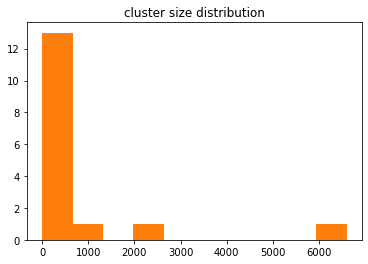

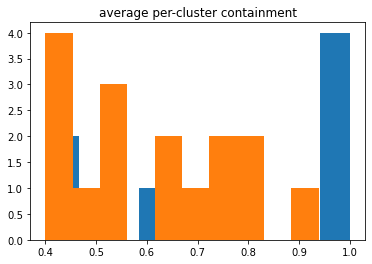

In [241]:
# plot histogram of cluster sizes
plt.hist(log_init_df.groupby('retained')['containment'].count())
plt.hist(log_tree_df.groupby('retained')['containment'].count())
plt.title("cluster size distribution")
plt.show()
# plot histogram of containment values
plt.hist(log_init_df.groupby('retained')['containment'].mean())
plt.hist(log_tree_df.groupby('retained')['containment'].mean())
plt.title("average per-cluster containment")
plt.show()

In [242]:
# combine the two cluster inputs
full_df = pd.concat([log_init_df, log_tree_df])
all_cluster_sizes = full_df.groupby('retained')['containment'].count()
all_cluster_mean_containment = full_df.groupby('retained')['containment'].mean()
all_cluster_sizes_sorted = all_cluster_sizes.sort_values(ascending = False)
all_cluster_sizes_sorted.head(10)

retained
WKW89187.1     6598
 WKW89176.1    1979
WKW89186.1      857
 ABK60202.1     172
 QCC38243.1      42
 UMW71117.1      23
UQR78808.1       10
 UQR78803.1       6
WKW89176.1        4
 UMW71122.1       3
Name: containment, dtype: int64

In [243]:
full_df['retained'] = [i.strip() for i in full_df['retained']]
full_df['discarded'] = [i.strip() for i in full_df['discarded']]

In [244]:
print(log_init_df.shape)
print(log_tree_df.shape)
print(full_df.shape)

(17, 3)
(9694, 3)
(9711, 3)


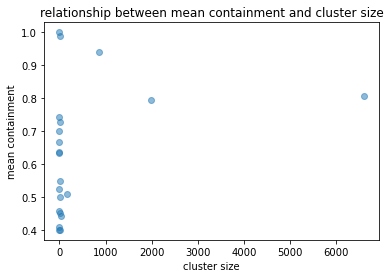

In [245]:
# plot to evaluate relationships between mean containment and cluster size 
# conclusion: most of the clusters with really low mean containment have just a few members in them 
plt.scatter(all_cluster_sizes, all_cluster_mean_containment, alpha = .5)
plt.title("relationship between mean containment and cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean containment")
plt.show()

In [246]:
# select just one cluster to investigate (based on input)
current_cluster_df = full_df[[cluster_id in i for i in list(full_df['retained'])]]

# select just one cluaster (based on size)
#top_cluster = str(all_cluster_sizes.head(1).index).split('|')[-2]
#current_cluster_df = full_df[[top_cluster in i for i in list(full_df['retained'])]]

'''# select the cluster with the lowest mean containment 
lowest_containment_cluster = full_df.groupby('retained')['containment'].mean().sort_values().head(1).index[0]
print(lowest_containment_cluster)
current_cluster_df = full_df[[lowest_containment_cluster in i for i in list(full_df['retained'])]]
print(current_cluster_df.shape)'''


if current_cluster_df.shape[0] > 100:
    current_cluster_df.sort_values(by='containment', ascending = True).head(100)
    #current_cluster_df = current_cluster_df[current_cluster_df['containment'] < .7].head(100)
# added to deal with case where cluster size is huge
print(current_cluster_df.shape)


(1, 3)


In [247]:
full_df.groupby('retained')['containment'].mean().sort_values()

retained
APB88858.1    0.400000
UQR78791.1    0.407407
UMW71119.1    0.429167
QCC38243.1    0.443184
UQR78803.1    0.497589
UMW71122.1    0.500000
ABK60202.1    0.508555
UQR78806.1    0.524071
UQR78808.1    0.549037
UQR78789.1    0.636364
UMW71115.1    0.666667
QCC38244.1    0.700000
UMW71117.1    0.727273
UQR78807.1    0.743590
WKW89176.1    0.793517
WKW89187.1    0.806859
WKW89186.1    0.938540
pdb|8D87|C    1.000000
Name: containment, dtype: float64

In [248]:
# NOTE: keep an eye here based on log file structure! may need to modify this
try: 
    # this is necessary given header structure for CHKV log
    current_cluster_df['seq_id'] = [i.split('|')[-2] for i in current_cluster_df['discarded']]
except: 
    # rhinovirus header structure differed, so this works for that case
    current_cluster_df['seq_id'] = [i for i in current_cluster_df['discarded']]
current_cluster_df

<ipython-input-248-4c1c7484fb2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_cluster_df['seq_id'] = [i for i in current_cluster_df['discarded']]


,discarded,retained,containment,seq_id
15,UQR78786.1,UQR78789.1,0.636364,UQR78786.1


In [249]:
# NOTE: keep an eye here based on log file structure! may need to modify this


# get all sequence names...
try:
    discarded_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['discarded'])]))
    retained_seqs = list(set([i.split('|')[-2] for i in list(current_cluster_df['retained'])]))
except:
    discarded_seqs = list(set([i for i in list(current_cluster_df['discarded'])]))
    retained_seqs = list(set([i for i in list(current_cluster_df['retained'])]))
all_seq_ids = {'discarded': discarded_seqs, 'retained':retained_seqs}
all_seq_ids_list = [i.strip() for i in discarded_seqs] + [i.strip() for i in retained_seqs] #discarded_seqs + retained_seqs

In [250]:
all_seq_ids_list

['UQR78786.1', 'UQR78789.1']

In [251]:
''' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)
! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"
! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook
'''

' # install eutils (instructions here: https://www.ncbi.nlm.nih.gov/books/NBK179288/)\n! sh -c "$(curl -fsSL https://ftp.ncbi.nlm.nih.gov/entrez/entrezdirect/install-edirect.sh)"\n! export PATH=${HOME}/edirect:${PATH} #not sure that this actually registers in the jupyter notebook\n'

In [252]:
# create an output directory based on initial input
! mkdir {output_dir}

mkdir: ./output1_prot/: File exists


In [253]:
# Get the .fasta files from genbank associated with all seqs
for this_seq in all_seq_ids_list:
    print(this_seq)
    print("working...")
    ! /Users/katrina.kalantar/edirect/esearch -db protein -query {this_seq} | /Users/katrina.kalantar/edirect/efetch -format fasta > {output_dir}{this_seq}.fasta


UQR78786.1
working...
UQR78789.1
working...


In [254]:
def protein_to_dna(protein_sequence):
    '''
    Given a protein sequence, reverse translate the sequence to produce a nucleotide sequence
    '''
    # Dictionary mapping amino acids to DNA codons
    codon_table = {
        'A': ['GCT', 'GCC', 'GCA', 'GCG'],
        'C': ['TGT', 'TGC'],
        'D': ['GAT', 'GAC'],
        'E': ['GAA', 'GAG'],
        'F': ['TTT', 'TTC'],
        'G': ['GGT', 'GGC', 'GGA', 'GGG'],
        'H': ['CAT', 'CAC'],
        'I': ['ATT', 'ATC', 'ATA'],
        'K': ['AAA', 'AAG'],
        'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
        'M': ['ATG'],
        'N': ['AAT', 'AAC'],
        'P': ['CCT', 'CCC', 'CCA', 'CCG'],
        'Q': ['CAA', 'CAG'],
        'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
        'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
        'T': ['ACT', 'ACC', 'ACA', 'ACG'],
        'V': ['GTT', 'GTC', 'GTA', 'GTG'],
        'W': ['TGG'],
        'Y': ['TAT', 'TAC'],
        'X': ['NNN'],
        'B': ['AAT', 'AAC'],
        '*': ['TAA', 'TAG', 'TGA']  # Stop codons
    }
    
    dna_sequence = ''
    
    # Convert each amino acid to the corresponding DNA codon
    for amino_acid in protein_sequence:
        codons = codon_table.get(amino_acid, [])
        if len(codons) == 0:
            raise ValueError(f"Invalid amino acid: {amino_acid}")
        
        # Choose a random codon for the amino acid
        codon = codons[0]  # Change this if you want a random codon
        
        dna_sequence += codon
    
    return dna_sequence


# write a nucleotide sequence version of the original input to file for use in data simulation step
#nt_filename = '.'.join(filename.split('/')[-1].split('.')[0:-1])  + '.ntseq.fasta'
#with open(nt_filename, 'w') as f:
#    f.write('>' + original_record.id + '_ntseq' + '\n')
#    f.write(protein_to_dna(original_record.seq))
#f.close()

In [255]:
# create the simulated files needed for alignment experiment!!

for this_seq in all_seq_ids_list:
    records = list(SeqIO.parse(output_dir + this_seq + '.fasta', "fasta"))
    #print(records)
    nr_seq = str(records[0].seq)
    #print(nr_seq)
    this_sequence = protein_to_dna(nr_seq)
    #print(this_sequence)
    new_record = SeqRecord(Seq(this_sequence.replace('NNNNN', '')), 
                           id=records[0].id, 
                           name=records[0].name, description=records[0].description)
    
    # write the new, no-Ns fasta sequence to a new file
    noN_filename = output_dir + this_seq + 'noN.fasta'
    SeqIO.write(new_record, noN_filename, "fasta")
    
    ! iss generate --genomes {noN_filename} --model miseq --output {output_dir + this_seq}.miseq_reads --n_reads 1000
    

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 1000 reads
INFO:iss.app:Generating reads for record: UQR78786.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete
INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 1000 reads
INFO:iss.app:Generating reads for record: UQR78789.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete


In [256]:
# run the alignment experiment for each discarded sequence and gather metrics

ref_seq = output_dir + all_seq_ids['retained'][0].strip() + '.fasta'
print(ref_seq)

results_dict = {}
skipped_count = 0

for this_seq in all_seq_ids['discarded']:#[0:2]:
    print(this_seq)
    input_r1 = output_dir + this_seq + '.miseq_reads_R1.fastq'
    input_r2 = output_dir + this_seq + '.miseq_reads_R2.fastq'
    input_r1r2 = output_dir + this_seq + '.miseq_reads_R1R2.fastq'
    
    results_dict[this_seq] = {}
    
    print(input_r1)
    print(input_r1r2)
    
    ! wc -l {input_r1}
    #! cat {input_r1} > {input_r1r2}
    ! cat {input_r1} {input_r2} > {input_r1r2}
    #! cat {input_r1} {input_r2} > {input_r1r2}
    ! wc -l {input_r1r2}
    
    # align reads only to the retained seq
    #! minimap2 -ax sr {ref_seq} {input_r1} {input_r2} > {output_dir + this_seq}.alnseq.sam
    ! diamond makedb --in {ref_seq} -d reference
    ! diamond blastx -d reference -q {input_r1r2} --mid-sensitive --outfmt 101 -o {output_dir + this_seq}.alnseq.sam
    #! samtools stats {output_dir + this_seq}.alnseq.sam > {output_dir + this_seq}.alnseq.stats.txt
    #unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alnseq.stats.txt
    unmapped_reads_string = ! grep -v "^@" {output_dir + this_seq}.alnseq.sam | cut -f3 | grep \* | wc -l
    
    try:
        print(unmapped_reads_string)
        unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
        print(unmapped_reads_count)
        results_dict[this_seq]['seqmap'] = unmapped_reads_count
        print(unmapped_reads_count)
    except:
        "too short seq, moving on"
        skipped_count+=1
        
    # align reads to the full clustered DB
    #! minimap2 -ax sr {clustered_db} {input_r1} {input_r2} > {output_dir + this_seq}.alndb.sam
    ! diamond makedb --in {clustered_db} -d reference
    ! diamond blastx -d reference -q {input_r1r2} --mid-sensitive --outfmt 101 -o {output_dir + this_seq}.alndb.sam
    #! samtools stats {output_dir + this_seq}.alndb.sam > {output_dir + this_seq}.alndb.stats.txt
    #unmapped_reads_string = ! grep "reads unmapped:" {output_dir + this_seq}.alndb.stats.txt
    unmapped_reads_string = ! grep -v "^@" {output_dir + this_seq}.alnseq.sam | cut -f3 | grep \* | wc -l
    print(unmapped_reads_string)
    try:
        unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
        print(unmapped_reads_count)
        results_dict[this_seq]['dbmap'] = unmapped_reads_count
        print(unmapped_reads_count)
    
        containment = current_cluster_df[current_cluster_df.seq_id==this_seq]['containment'].iloc[0]
        results_dict[this_seq]['containment'] = containment

        print(results_dict[this_seq])
        print("-------")
        print("\n\n")
    except:
        "too short seq, moving on"
        skipped_count+=1
        
print("SKIPPED COUNT: " + str(skipped_count))


./output1_prot/UQR78789.1.fasta
UQR78786.1
./output1_prot/UQR78786.1.miseq_reads_R1.fastq
./output1_prot/UQR78786.1.miseq_reads_R1R2.fastq
    2000 ./output1_prot/UQR78786.1.miseq_reads_R1.fastq
    4000 ./output1_prot/UQR78786.1.miseq_reads_R1R2.fastq
diamond v2.1.6.160 (C) Max Planck Society for the Advancement of Science
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 16
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: ./output1_prot/UQR78789.1.fasta
Opening the database file...  [0s]
Loading sequences...  [0s]
Masking sequences...  [0s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  1
  Database letters  261
     Database hash  bd7a4dc04b17996d1519f2058de08843
        To

Building reference seed array...  [0.001s]
Building query seed array...  [0.002s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 2/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.002s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 3/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.002s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 7/8, index chunk 4/4.
Building reference seed array...  [0.001s]
Building query seed array...  [0.002s]
Computing hash join...  [0s]
Masking low complexity seeds... 

Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 6/8, index chunk 1/4.
Building reference seed array...  [0s]
Building query seed array...  [0.002s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.001s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1, shape 6/8, index chunk 2/4.
Building reference seed array...  [0s]
Building query seed array...  [0.003s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0.002s]
Deallocating memory...  [0.001s]
Processing query block 1, reference block 1/1, shape 6/8, index chunk 3/4.
Building reference seed array...  [0.002s]
Building query seed array...  [0.001s]
Computing hash join...  [0s]
Masking low complexity seeds...  [0s]
Searching alignments...  [0s]
Deallocating memory...  [0s]
Processing query block 1, reference block 1/1,

In [257]:
mapping_results_df = pd.DataFrame.from_dict(results_dict, orient='index')
mapping_results_df

,seqmap,dbmap,containment
UQR78786.1,1,1,0.636364


In [258]:
# OPTIONAL -- do pairwise sequence alignment and investigate the output

ref_seq = output_dir + all_seq_ids['retained'][0] + '.fasta'
all_results = {}

for this_seq in all_seq_ids['discarded']:
    ! cat {ref_seq} {output_dir + this_seq}.fasta > {output_dir + this_seq}.muscle.fasta
    ! muscle -in {output_dir + this_seq}.muscle.fasta -out {output_dir + this_seq}.aln 
    
    
    
    records = list(SeqIO.parse( output_dir + this_seq + ".aln", "fasta"))   
    
    
    seq_ref = str(records[0].seq)
    seq_b = str(records[1].seq)
    
    pairs = []
    for i in range(len(seq_ref)):
        pairs.append(seq_ref[i] + '/' + seq_b[i])

    tally = Counter(pairs)

    result={}

    result['ESref'] = tally['-/A'] + tally['-/C'] + tally['-/G'] + tally['-/T']
    result['ESb'] = tally['A/-'] + tally['C/-'] + tally['G/-'] + tally['T/-']
    result['ENref'] = tally['N/-'] 
    result['ENb'] = tally['-/N'] 
    result['Nref'] = tally['N/A'] + tally['N/C'] + tally['N/G'] + tally['N/T']
    result['Nb'] = tally['A/N'] + tally['G/N'] + tally['C/N'] + tally['T/N']
    result['match'] = tally['A/A'] + tally['G/G'] + tally['C/C'] + tally['T/T']
    result['mismatch'] = tally['A/C'] + tally['A/G'] + tally['A/T'] + tally['C/A'] + tally['C/G'] + tally['C/T'] + tally['G/A'] + tally['G/C'] + tally['G/T'] + tally['T/A'] + tally['T/C'] + tally['T/G']
    result['alignment length'] = len(seq_ref)
    result['seq_length'] = len(seq_b.replace('-',''))
    
    result['pid'] = np.round(result['match'] / (result['match'] + result['mismatch'] ), 3)
    print(result)
    
    all_results[this_seq] = result
    
    print("\n\n")
    


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

UQR78786.1.muscle 2 seqs, lengths min 261, max 261, avg 261
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      2 MB(0%)  Iter   1  100.00%  Align node       
00:00:00      2 MB(0%)  Iter   1  100.00%  Root alignment
{'ESref': 0, 'ESb': 0, 'ENref': 0, 'ENb': 0, 'Nref': 0, 'Nb': 0, 'match': 54, 'mismatch': 1, 'alignment length': 261, 'seq_length': 261, 'pid': 0.982}





In [259]:
pairwise_results_df = pd.DataFrame.from_dict(all_results, orient='index')
pairwise_results_df

,ESref,ESb,ENref,ENb,Nref,Nb,match,mismatch,alignment length,seq_length,pid
UQR78786.1,0,0,0,0,0,0,54,1,261,261,0.982


In [260]:
joint_results_df = pd.concat([mapping_results_df, pairwise_results_df], axis=1)
joint_results_df.sort_values(by='containment', ascending = True, inplace=True)
joint_results_df

,seqmap,dbmap,containment,ESref,ESb,ENref,ENb,Nref,Nb,match,mismatch,alignment length,seq_length,pid
UQR78786.1,1,1,0.636364,0,0,0,0,0,0,54,1,261,261,0.982


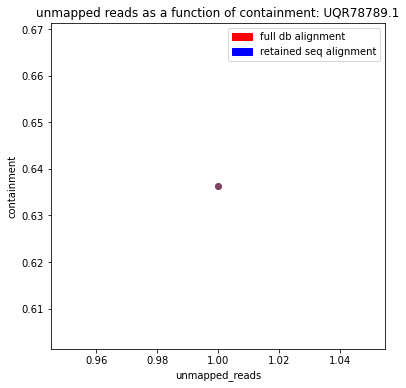

In [261]:
plt.figure(figsize=(6,6))
plt.scatter(joint_results_df['seqmap'], joint_results_df['containment'], zorder=0)
plt.scatter(joint_results_df['dbmap'], joint_results_df['containment'], zorder=1, color='red', alpha=.4)
plt.xlabel('unmapped_reads')
plt.ylabel('containment')
plt.title('unmapped reads as a function of containment: ' + current_cluster_df['retained'].iloc[0])

red_patch = mpatches.Patch(color='red', label='full db alignment')
blue_patch = mpatches.Patch(color='blue', label='retained seq alignment')
plt.legend(handles=[red_patch, blue_patch])

#plt.scatter(x1,y1,marker = 'o', s = 6, color = 'r', zorder=1)

#ax1 = joint_results_df[['seqmap', 'containment']].plot(kind='scatter', x= 'seqmap', y='containment')
#joint_results_df[['dbmap', 'containment']].plot(kind='scatter', x= 'dbmap', y='containment', axis=ax1)